In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

# Qiskit imports
from circuit_knitting.cutting import partition_problem
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import SparsePauliOp, PauliList
from qiskit.visualization import circuit_drawer
from qiskit_algorithms.optimizers.cobyla import COBYLA
from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit_algorithms.utils import algorithm_globals

/var/folders/3j/3p_dzlvs1nsdfryf9hm7gjnr0000gn/T/ipykernel_73553/2503536757.py:13: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA


In [2]:
seed = 100

## Data Loading

In [3]:
# Load data
data = pd.read_csv("diabetes_normalized.csv")
data = data.drop(["Unnamed: 0"], axis=1)
# data = data.drop(["BMI", "SkinThickness", "Pregnancies"], axis=1)
data.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.923998,1.531329,0.566517,-0.920265,-3.141593,0.004682,-1.66872,-0.104720,1
1,-2.771994,-0.457820,0.257508,-1.301064,-3.141593,-0.650792,-2.40918,-2.094395,0


In [4]:
y = data["Outcome"]
x = data.drop(["Outcome"], axis=1)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(537, 8) (537,) (231, 8) (231,)


In [6]:
x_train_A = x_train.iloc[:, :4]
x_train_B = x_train.iloc[:, 4:]
# x_train.iloc[:, 4:]

In [7]:
x_test_A = x_test.iloc[:, :4]
x_test_B = x_test.iloc[:, 4:]

In [8]:
# y_train

## Data Embedding

In [9]:
# Data Embedding - Angle Encoding
def angle_encoding(feature_dims: int):
    embedding = QuantumCircuit(feature_dims)
    feature_param = ParameterVector("Theta", feature_dims)
    for qubit in range(feature_dims):
        embedding.ry(feature_param[qubit], qubit)
    return embedding, feature_param

In [10]:
embedding, feature_params = angle_encoding(4)

## Tensor Network

In [11]:
from ttn import TTN

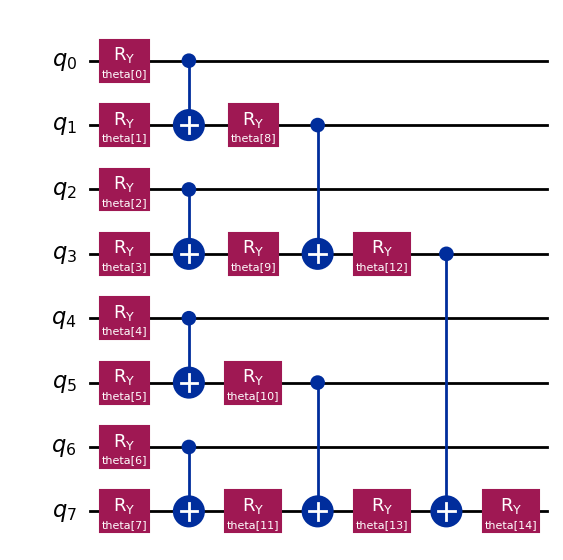

In [12]:
ttn = TTN(num_qubits=8).ttn_simple(complex_structure=False)
ttn.draw("mpl", style="iqp")

In [13]:
# ttn.parameters

## Circuit Cutting

In [14]:
observables = PauliList(["ZIIIIIII"])
partitioned_problem = partition_problem(circuit=ttn, partition_labels="AAAABBBB", observables=observables)
sub_circuits = partitioned_problem.subcircuits
sub_observables = partitioned_problem.subobservables
bases = partitioned_problem.bases

In [15]:
sub_observables

{'A': PauliList(['IIII']), 'B': PauliList(['ZIII'])}

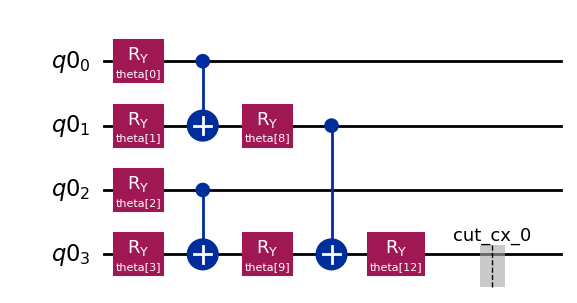

In [16]:
sub_circuits["A"].draw("mpl", style="iqp")

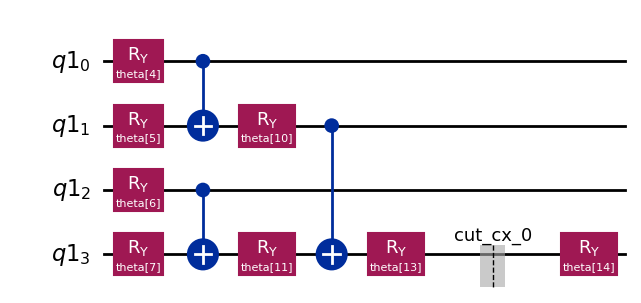

In [17]:
sub_circuits["B"].draw("mpl", style="iqp")

In [18]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 9.0


### Sub Experiments

In [19]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=sub_circuits, observables=sub_observables, num_samples=np.inf
)

In [20]:
# subexperiments
len(subexperiments["A"])

6

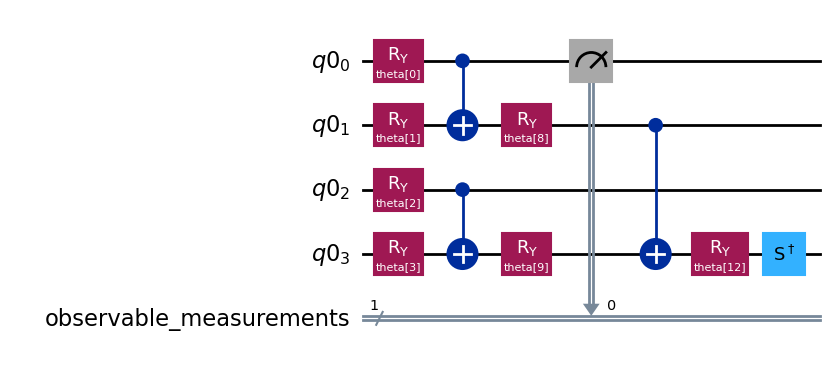

In [21]:
subexperiments["A"][0].draw("mpl", style="iqp")

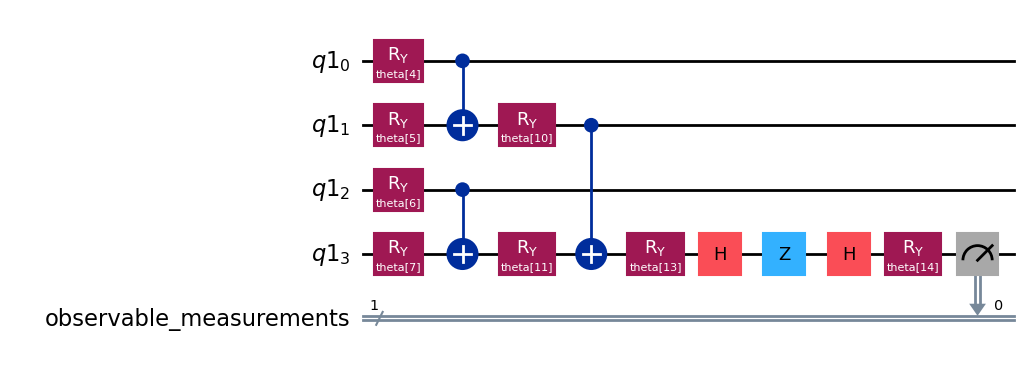

In [22]:
subexperiments["B"][3].draw("mpl", style="iqp")

## Neural Network Training

In [23]:
from custom_sampler_qnn import CustomSampler

### Sampler

#### For subexperiments["A"]

In [24]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]
# final_circuits[0].draw("mpl")

In [25]:
sampler_qcnn = CustomSampler(
    circuits=final_circuits, 
    input_params=feature_params.params,
    weight_params=sub_circuits["A"].parameters,
    input_gradients=False
)

In [26]:
weights_A = algorithm_globals.random.random(7)
# forward_output, forward_sampler_result

forward_output = sampler_qcnn.forward(
    input_data=x_train_A,
    weights=weights_A,
)

In [27]:
# forward output is a dictionary of 6 subex_circ items.
print(f"Output shape for {len(x_train_A)} samples: {forward_output[0].shape}")
print(len(forward_output[0]))
print(f"Output of the forward pass for first sample: \n{np.array([forward_output[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16)
537
Output of the forward pass for first sample: 
[[0.03710938 0.96289062 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.04199219 0.95800781 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.02050781 0.34082031 0.01660156 0.62207031 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.02148438 0.33300781 0.01171875 0.63378906 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.03222656 0.96777344 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.04199219 0.95800781 0.         0.         0.         0.
  0.         0.

In [28]:
input_grad, weights_grad = sampler_qcnn.backward(
    input_data=x_train_A,
    weights=weights_A
)

In [29]:
print(f"Output shape for {len(x_train_A)} samples: {weights_grad[0].shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: \n{np.array([weights_grad[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16, 7)
Output of the backward pass for first sample for first subexperiment circuit: 
[[[ 0.36914062  0.          0.          0.          0.
    0.          0.        ]
  [-0.36914062  0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.      

#### For subexperiments["B"]

In [30]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [31]:
sampler_qcnn2 = CustomSampler(
    circuits=final_circuits2, 
    input_params=feature_params.params,
    weight_params=sub_circuits["B"].parameters,
)

In [32]:
weights_B = algorithm_globals.random.random(8)
forward_output2 = sampler_qcnn2._forward(
    input_data=x_train_B,
    weights=weights_B,
)

In [33]:
print(f"Output shape for {len(x_train_B)} samples: {forward_output2[0].shape}")
print(len(forward_output2[0]))
print(f"Output of the forward pass for first sample: \n{np.array([forward_output2[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16)
537
Output of the forward pass for first sample: 
[[0.53417969 0.46582031 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.53027344 0.46972656 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.41210938 0.58789062 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.65722656 0.34277344 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.10742188 0.30175781 0.44628906 0.14453125 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.10449219 0.31738281 0.42089844 0.15722656 0.         0.
  0.         0.

In [34]:
input_grad2, weights_grad2 = sampler_qcnn2._backward(
    input_data=x_train_B,
    weights=weights_B
)

In [35]:
print(f"Output shape for {len(x_train_B)} samples: {weights_grad[0].shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: \n{np.array([weights_grad[i][0] for i in range(6)])}")

Output shape for 537 samples: (537, 16, 7)
Output of the backward pass for first sample for first subexperiment circuit: 
[[[ 0.36914062  0.          0.          0.          0.
    0.          0.        ]
  [-0.36914062  0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.          0.
    0.          0.        ]
  [ 0.          0.          0.          0.      

## Loss and Optimization

In [36]:
from qiskit_machine_learning.utils.loss_functions import L2Loss
from qiskit_algorithms.optimizers import COBYLA, SPSA, GradientDescent
from objective_func import CustomMultiClassObjectiveFunction
from optimization import create_objective, minimizer, print_optimizer_results

In [37]:
def callback(nfev, params, fval, stepsize, accepted=None):
    global objective_func_vals

    if (nfev % 3) == 0:
        objective_func_vals.append(fval)
        print(f"SPSA Epoch {len(objective_func_vals)}: {fval:.5f}")

In [38]:
objective_func_vals = []
loss = L2Loss()
# optimizer = COBYLA(maxiter=10)
optimizer = SPSA(maxiter=10, callback=callback)
# optimizer = GradientDescent(maxiter=2) # This doesn't work yet. The gradient shape doesn't match.

In [39]:
# objective = create_objective(x_train_A, y_train, sampler_qcnn, loss)
initial_point = np.random.random((7,))
function = CustomMultiClassObjectiveFunction(x_train_A, y_train, sampler_qcnn, loss)

In [ ]:
function.objective0(initial_point)

In [ ]:
function.gradient0(initial_point)

In [40]:
# Optimizing sub-experiment-0
optimizer_result = minimizer(function, function.objective0, function.gradient0, initial_point, optimizer)

SPSA Epoch 1: 0.52575
SPSA Epoch 2: 0.44691
SPSA Epoch 3: 0.39526
SPSA Epoch 4: 0.37572
SPSA Epoch 5: 0.36687
SPSA Epoch 6: 0.36395
SPSA Epoch 7: 0.36135
SPSA Epoch 8: 0.36056
SPSA Epoch 9: 0.36033
SPSA Epoch 10: 0.36070
{   'fun': 0.3607007245111732,
    'jac': None,
    'nfev': 30,
    'nit': 10,
    'njev': None,
    'x': array([ 2.41026937,  2.25592642, -0.14782284,  0.14296764,  1.77975946,
        0.99484641,  1.11985443])}


In [41]:
print_optimizer_results(optimizer_result)

New params (The final point of the minimization): [ 2.41026937  2.25592642 -0.14782284  0.14296764  1.77975946  0.99484641
  1.11985443]
The final value of the minimization: 0.3607007245111732
The final gradient of the minimization: None
The total number of function evaluations: 30
The total number of gradient evaluations: None
The total number of iterations: 10


Text(0.5, 1.0, 'Training loss')

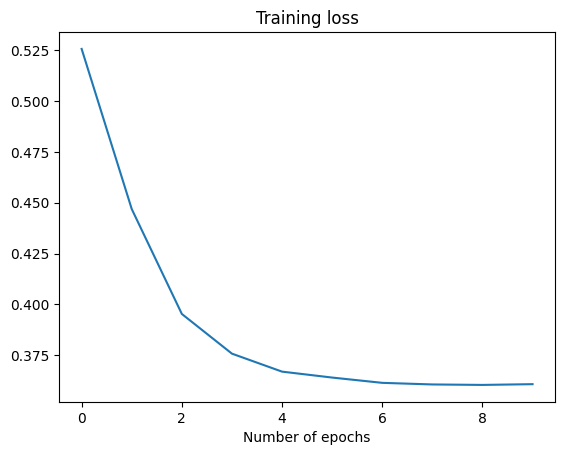

In [42]:
plt.plot(objective_func_vals)
plt.xlabel("Number of epochs")
plt.title("Training loss")

## Reconstruct Expectation Values

In [ ]:
from circuit_knitting.cutting import reconstruct_expectation_values

In [ ]:
import copy

empty_dict = {}
for num_samples in range(537):
    empty_dict[num_samples] = []

dists_dict = copy.deepcopy(empty_dict)
metadata_dict = copy.deepcopy(empty_dict)

for num_samples in range(537):
    for k, v in forward_sampler_result.items():
        # print(num_samples, k, v.quasi_dists[num_samples])
        dists_dict[num_samples].append(v.quasi_dists[num_samples])
        metadata_dict[num_samples].append(v.metadata[num_samples])

A_dict = copy.deepcopy(empty_dict)
for key, item in new_dict.items():
    A_dict[key] = SamplerResult(quasi_dists=dists_dict[key], metadata=metadata_dict[key])

print(len(dists_dict), len(metadata_dict[0]))
print(len(A_dict), len(A_dict[0].quasi_dists), len(A_dict[0].metadata))

In [ ]:
# B_dict

dists_dict = copy.deepcopy(empty_dict)
metadata_dict = copy.deepcopy(empty_dict)

for num_samples in range(537):
    for k, v in forward_sampler_result2.items():
        # print(num_samples, k, v.quasi_dists[num_samples])
        dists_dict[num_samples].append(v.quasi_dists[num_samples])
        metadata_dict[num_samples].append(v.metadata[num_samples])

B_dict = copy.deepcopy(empty_dict)
for key, item in new_dict.items():
    B_dict[key] = SamplerResult(quasi_dists=dists_dict[key], metadata=metadata_dict[key])

print(len(dists_dict), len(metadata_dict[0]))
print(len(B_dict), len(B_dict[0].quasi_dists), len(B_dict[0].metadata))

In [ ]:
# combine dicts
combine_dict = {"A": None, "B": None}
reconstructed_expvals = []

zip_dict = zip(A_dict.items(), B_dict.items())
# print(zip_dict)
for (num_subex1, v1), (num_subex2, v2) in zip_dict:
    # print((num_subex1, v1), (num_subex2, v2))
    combine_dict["A"] = v1
    combine_dict["B"] = v2
    reconstructed_expvals.append(
        reconstruct_expectation_values(
            combine_dict,
            coefficients,
            sub_observables,
        )[0]
    )

# print(combine_dict)